In [1]:
from pathlib import Path
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from metric import apk, mapk
from utils import plot_images

In [2]:
dataset = '10'

transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
users = pd.read_pickle(f"input/{dataset}/users.pkl")
items = pd.read_pickle(f"input/{dataset}/items.pkl")
merged = pd.read_pickle("output/merged.pkl")

In [10]:
num_week = 3
num_user_transactions = transactions.query('week <= @num_week').groupby('user').size().reset_index(name='num_transactions')

In [6]:
merged['apk'] = merged.apply(lambda x: apk(x['gt'], x['item']), axis=1)
merged = merged.merge(num_user_transactions, on='user').fillna(0)

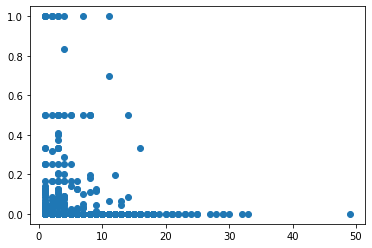

In [13]:
plt.scatter(merged['num_transactions'], merged['apk'])